In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline as ImbPipeline


# Data Preprocessing and EDA

In [2]:
# Set up
matches = pd.read_csv("./combined_la_liga.csv")

In [3]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2018-08-17,22:15,La Liga,Matchweek 1,Fri,Home,L,0.0,3.0,Levante,...,Match Report,NaN,22.0,8.0,21.7,0.0,0,0,2019,Real Betis
1,2018-08-17,20:15,La Liga,Matchweek 1,Fri,Away,D,0.0,0.0,Girona,...,Match Report,NaN,2.0,1.0,30.8,0.0,0,0,2019,Valladolid
2,2018-08-17,20:15,La Liga,Matchweek 1,Fri,Home,D,0.0,0.0,Valladolid,...,Match Report,NaN,13.0,1.0,20.9,0.0,0,0,2019,Girona
3,2018-08-17,22:15,La Liga,Matchweek 1,Fri,Away,W,3.0,0.0,Betis,...,Match Report,NaN,6.0,4.0,12.5,0.0,0,0,2019,Levante
4,2018-08-18,20:15,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,Villarreal,...,Match Report,NaN,9.0,4.0,19.0,0.0,0,0,2019,Real Sociedad


In [4]:
matches.shape

(4979, 28)

In [5]:
matches["team"].value_counts()

team
Athletic Club      247
Barcelona          247
Real Madrid        247
Real Betis         246
Villarreal         246
Atletico Madrid    246
Valencia           246
Getafe             246
Sevilla            246
Celta Vigo         246
Real Sociedad      246
Alaves             208
Osasuna            208
Rayo Vallecano     198
Espanyol           197
Mallorca           171
Valladolid         170
Granada            152
Levante            152
Cadiz              152
Girona             132
Elche              114
Eibar              114
Leganes             94
Huesca              76
Almeria             76
Las Palmas          56
Name: count, dtype: int64

In [6]:
matches["round"].value_counts()

round
Matchweek 1     142
Matchweek 11    142
Matchweek 2     142
Matchweek 18    142
Matchweek 17    142
Matchweek 16    142
Matchweek 15    142
Matchweek 14    142
Matchweek 13    142
Matchweek 12    142
Matchweek 10    142
Matchweek 9     142
Matchweek 8     142
Matchweek 7     142
Matchweek 6     142
Matchweek 5     142
Matchweek 4     142
Matchweek 3     142
Matchweek 19    126
Matchweek 24    122
Matchweek 28    122
Matchweek 27    122
Matchweek 25    122
Matchweek 20    122
Matchweek 23    122
Matchweek 22    122
Matchweek 21    122
Matchweek 26    121
Matchweek 29    120
Matchweek 30    120
Matchweek 31    120
Matchweek 32    120
Matchweek 33    120
Matchweek 34    120
Matchweek 35    120
Matchweek 36    120
Matchweek 37    120
Matchweek 38    120
Name: count, dtype: int64

In [7]:
matches.dtypes

date              object
time              object
comp              object
round             object
day               object
venue             object
result            object
gf               float64
ga               float64
opponent          object
xg               float64
xga              float64
poss             float64
attendance       float64
captain           object
formation         object
opp formation     object
referee           object
match report      object
notes            float64
sh               float64
sot              float64
dist             float64
fk               float64
pk                 int64
pkatt              int64
season             int64
team              object
dtype: object

In [8]:
matches.reset_index(inplace=True)  # Moves the index to a column
matches["date"] = pd.to_datetime(matches["date"])  # Convert to datetime
matches.dtypes

index                     int64
date             datetime64[ns]
time                     object
comp                     object
round                    object
day                      object
venue                    object
result                   object
gf                      float64
ga                      float64
opponent                 object
xg                      float64
xga                     float64
poss                    float64
attendance              float64
captain                  object
formation                object
opp formation            object
referee                  object
match report             object
notes                   float64
sh                      float64
sot                     float64
dist                    float64
fk                      float64
pk                        int64
pkatt                     int64
season                    int64
team                     object
dtype: object

In [9]:
matches["venue_code"] = matches["venue"].astype('category').cat.codes
matches


,index,date,time,comp,round,day,venue,result,gf,ga,...,notes,sh,sot,dist,fk,pk,pkatt,season,team,venue_code
0,0,2018-08-17,22:15,La Liga,Matchweek 1,Fri,Home,L,0.0,3.0,...,NaN,22.0,8.0,21.7,0.0,0,0,2019,Real Betis,1
1,1,2018-08-17,20:15,La Liga,Matchweek 1,Fri,Away,D,0.0,0.0,...,NaN,2.0,1.0,30.8,0.0,0,0,2019,Valladolid,0
2,2,2018-08-17,20:15,La Liga,Matchweek 1,Fri,Home,D,0.0,0.0,...,NaN,13.0,1.0,20.9,0.0,0,0,2019,Girona,1
3,3,2018-08-17,22:15,La Liga,Matchweek 1,Fri,Away,W,3.0,0.0,...,NaN,6.0,4.0,12.5,0.0,0,0,2019,Levante,0
4,4,2018-08-18,20:15,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,...,NaN,9.0,4.0,19.0,0.0,0,0,2019,Real Sociedad,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4974,4974,2025-03-01,16:15,La Liga,Matchweek 26,Sat,Home,D,1.0,1.0,...,NaN,20.0,8.0,17.0,0.0,0,0,2024,Rayo Vallecano,1
4975,4975,2025-03-09,16:15,La Liga,Matchweek 27,Sun,Away,L,1.0,2.0,...,NaN,20.0,6.0,19.7,0.0,0,0,2024,Rayo Vallecano,0
4976,4976,2025-03-10,21:00,La Liga,Matchweek 27,Mon,Home,D,1.0,1.0,...,NaN,7.0,4.0,21.2,0.0,0,0,2024,Espanyol,1
4977,4977,2025-03-15,16:15,La Liga,Matchweek 28,Sat,Away,L,1.0,2.0,...,NaN,2.0,0.0,16.1,0.0,0,0,2024,Espanyol,0


In [10]:
matches['opp_code'] = matches['opponent'].astype('category').cat.codes
# Extract the mapping for opponents
opponent_mapping = dict(enumerate(matches['opponent'].astype('category').cat.categories))
# Display the mapping
print("Opponent to Code Mapping:")
for code, opponent in opponent_mapping.items():
    print(f"{code}: {opponent}")

matches['team'] = matches['team'].astype('category').cat.codes
team_mapping = dict(enumerate(matches['team'].astype('category').cat.categories))
# Display the mapping
print("Team to Code Mapping:")
for code, team in team_mapping.items():
    print(f"{code}: {team}")

Opponent to Code Mapping:
0: Alavés
1: Almería
2: Athletic Club
3: Atlético Madrid
4: Barcelona
5: Betis
6: Celta Vigo
7: Cádiz
8: Eibar
9: Elche
10: Espanyol
11: Getafe
12: Girona
13: Granada
14: Huesca
15: Las Palmas
16: Leganés
17: Levante
18: Mallorca
19: Osasuna
20: Rayo Vallecano
21: Real Madrid
22: Real Sociedad
23: Sevilla
24: Valencia
25: Valladolid
26: Villarreal
Team to Code Mapping:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 10
11: 11
12: 12
13: 13
14: 14
15: 15
16: 16
17: 17
18: 18
19: 19
20: 20
21: 21
22: 22
23: 23
24: 24
25: 25
26: 26


In [11]:
matches['hour'] = matches['time'].str.replace(':.+','',regex=True).astype('int')
# matches
matches['day_code'] = matches['date'].dt.dayofweek
# matches
# Map results to numerical values: W = 2, D = 1, L = 0
matches['target'] = matches['result'].map({'W': 2, 'D': 1, 'L': 0})
matches

,index,date,time,comp,round,day,venue,result,gf,ga,...,fk,pk,pkatt,season,team,venue_code,opp_code,hour,day_code,target
0,0,2018-08-17,22:15,La Liga,Matchweek 1,Fri,Home,L,0.0,3.0,...,0.0,0,0,2019,20,1,17,22,4,0
1,1,2018-08-17,20:15,La Liga,Matchweek 1,Fri,Away,D,0.0,0.0,...,0.0,0,0,2019,25,0,12,20,4,1
2,2,2018-08-17,20:15,La Liga,Matchweek 1,Fri,Home,D,0.0,0.0,...,0.0,0,0,2019,11,1,25,20,4,1
3,3,2018-08-17,22:15,La Liga,Matchweek 1,Fri,Away,W,3.0,0.0,...,0.0,0,0,2019,16,0,5,22,4,2
4,4,2018-08-18,20:15,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,...,0.0,0,0,2019,22,0,26,20,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4974,4974,2025-03-01,16:15,La Liga,Matchweek 26,Sat,Home,D,1.0,1.0,...,0.0,0,0,2024,19,1,23,16,5,1
4975,4975,2025-03-09,16:15,La Liga,Matchweek 27,Sun,Away,L,1.0,2.0,...,0.0,0,0,2024,19,0,21,16,6,0
4976,4976,2025-03-10,21:00,La Liga,Matchweek 27,Mon,Home,D,1.0,1.0,...,0.0,0,0,2024,9,1,12,21,0,1
4977,4977,2025-03-15,16:15,La Liga,Matchweek 28,Sat,Away,L,1.0,2.0,...,0.0,0,0,2024,9,0,18,16,5,0


In [12]:
def rolling_average(group, cols, new_cols):
    # Sort by date to ensure proper rolling calculations
    group = group.sort_values('date')

    # Calculate rolling averages for the specified columns
    rolling_stats = group[cols].rolling(5, closed='left').mean()

    # Assign the rolling averages to new columns in the DataFrame
    for col, new_col in zip(cols, new_cols):
        group[new_col] = rolling_stats[col]

    # Drop rows with NaN values (occurs for the first few rows before the rolling window is complete)
    group = group.dropna(subset=new_cols)

    return group

In [13]:
# List of columns for which to calculate rolling averages
cols = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']

# Names of the new rolling average columns
new_cols = [f'{c}_rolling' for c in cols]

In [14]:
# Group by team and apply rolling averages
matches_rolling = matches.groupby('team').apply(lambda x: rolling_average(x, cols, new_cols))
# Reset index after applying groupby to flatten the DataFrame
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.reset_index(drop=True, inplace=True)

/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_45509/2239408330.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby('team').apply(lambda x: rolling_average(x, cols, new_cols))


In [15]:
print(matches_rolling.columns)

Index(['index', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result',
       'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain',
       'formation', 'opp formation', 'referee', 'match report', 'notes', 'sh',
       'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'venue_code',
       'opp_code', 'hour', 'day_code', 'target', 'gf_rolling', 'ga_rolling',
       'sh_rolling', 'sot_rolling', 'dist_rolling', 'fk_rolling', 'pk_rolling',
       'pkatt_rolling'],
      dtype='object')


In [16]:
matches_rolling

,index,date,time,comp,round,day,venue,result,gf,ga,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,116,2018-09-27,20:00,La Liga,Matchweek 6,Thu,Home,D,1.0,1.0,...,3,1,1.6,1.0,9.6,4.0,19.02,0.2,0.0,0.0
1,131,2018-09-30,18:30,La Liga,Matchweek 7,Sun,Away,L,1.0,2.0,...,6,0,1.8,0.6,11.8,4.2,20.26,0.2,0.0,0.2
2,140,2018-10-06,18:30,La Liga,Matchweek 8,Sat,Home,W,1.0,0.0,...,5,2,2.0,1.0,11.2,3.8,19.60,0.4,0.0,0.2
3,158,2018-10-19,21:00,La Liga,Matchweek 9,Fri,Away,W,1.0,0.0,...,4,2,1.8,0.8,11.2,3.6,21.32,0.4,0.0,0.2
4,192,2018-10-28,18:30,La Liga,Matchweek 10,Sun,Home,W,2.0,1.0,...,6,2,1.8,0.8,11.0,3.2,21.44,0.8,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,4879,2024-12-01,14:00,La Liga,Matchweek 15,Sun,Home,D,2.0,2.0,...,6,1,1.6,1.2,14.0,4.4,17.00,0.4,0.4,0.4
4830,4898,2024-12-08,16:15,La Liga,Matchweek 16,Sun,Away,L,0.0,2.0,...,6,0,2.0,1.2,14.2,5.0,16.48,0.2,0.4,0.4
4831,4920,2024-12-15,18:30,La Liga,Matchweek 17,Sun,Home,L,1.0,2.0,...,6,0,1.8,1.4,14.4,4.4,16.70,0.2,0.4,0.4
4832,4934,2024-12-18,21:30,La Liga,Matchweek 12,Wed,Home,D,1.0,1.0,...,2,1,1.6,1.6,13.6,3.2,16.40,0.2,0.4,0.4


In [17]:
# List of columns to keep
columns_to_keep = ['date', 'venue_code', 'opp_code', 'day_code', 'hour',
                   'gf_rolling', 'ga_rolling', 'sh_rolling', 'sot_rolling',
                   'dist_rolling', 'fk_rolling', 'pk_rolling', 'pkatt_rolling', 'team','target']

# Drop all other columns
matches_rolling = matches_rolling[columns_to_keep]
matches_rolling

,date,venue_code,opp_code,day_code,hour,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,team,target
0,2018-09-27,1,11,3,20,1.6,1.0,9.6,4.0,19.02,0.2,0.0,0.0,0,1
1,2018-09-30,0,17,6,18,1.8,0.6,11.8,4.2,20.26,0.2,0.0,0.2,0,0
2,2018-10-06,1,21,5,18,2.0,1.0,11.2,3.8,19.60,0.4,0.0,0.2,0,2
3,2018-10-19,0,6,4,21,1.8,0.8,11.2,3.6,21.32,0.4,0.0,0.2,0,2
4,2018-10-28,1,26,6,18,1.8,0.8,11.0,3.2,21.44,0.8,0.0,0.2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,2024-12-01,1,12,6,14,1.6,1.2,14.0,4.4,17.00,0.4,0.4,0.4,26,1
4830,2024-12-08,0,2,6,16,2.0,1.2,14.2,5.0,16.48,0.2,0.4,0.4,26,0
4831,2024-12-15,1,5,6,18,1.8,1.4,14.4,4.4,16.70,0.2,0.4,0.4,26,0
4832,2024-12-18,1,20,2,21,1.6,1.6,13.6,3.2,16.40,0.2,0.4,0.4,26,1


In [18]:
# Step 1: Create rolling averages for each team (already done as matches_rolling)
matches_rolling = matches.groupby('team').apply(
    lambda x: rolling_average(x, cols, new_cols)
).droplevel('team').reset_index(drop=True)

# Step 2: Merge opponent rolling averages
# Join the rolling averages of the opponent into the main DataFrame
opponent_rolling = matches_rolling[['team', 'date'] + new_cols].rename(
    columns={col: f'opp_{col}' for col in new_cols}
)

# Merge the opponent's rolling averages based on the match date and opponent code
matches_with_opponent = matches_rolling.merge(
    opponent_rolling,
    left_on=['opp_code', 'date'],
    right_on=['team', 'date'],
    suffixes=('', '_opp'),
    how='left'
)

# Drop the redundant 'team_opp' column created by the merge
matches_with_opponent = matches_with_opponent.drop(columns=['team_opp'])

/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_45509/3921506864.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby('team').apply(


In [19]:
matches_with_opponent.columns

Index(['index', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result',
       'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain',
       'formation', 'opp formation', 'referee', 'match report', 'notes', 'sh',
       'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'venue_code',
       'opp_code', 'hour', 'day_code', 'target', 'gf_rolling', 'ga_rolling',
       'sh_rolling', 'sot_rolling', 'dist_rolling', 'fk_rolling', 'pk_rolling',
       'pkatt_rolling', 'opp_gf_rolling', 'opp_ga_rolling', 'opp_sh_rolling',
       'opp_sot_rolling', 'opp_dist_rolling', 'opp_fk_rolling',
       'opp_pk_rolling', 'opp_pkatt_rolling'],
      dtype='object')

In [20]:
columns_to_keep = ['date', 'venue_code', 'opp_code', 'hour', 'day_code', 'team',
                   'gf_rolling', 'ga_rolling', 'sh_rolling', 'sot_rolling',
                   'dist_rolling', 'fk_rolling', 'pk_rolling', 'pkatt_rolling',
                   'opp_gf_rolling', 'opp_ga_rolling', 'opp_sh_rolling',
                   'opp_sot_rolling', 'opp_dist_rolling', 'opp_fk_rolling',
                   'opp_pk_rolling', 'opp_pkatt_rolling', 'target']

# Keep only these columns
matches_cleaned = matches_with_opponent[columns_to_keep]

In [21]:
matches_cleaned.columns

Index(['date', 'venue_code', 'opp_code', 'hour', 'day_code', 'team',
       'gf_rolling', 'ga_rolling', 'sh_rolling', 'sot_rolling', 'dist_rolling',
       'fk_rolling', 'pk_rolling', 'pkatt_rolling', 'opp_gf_rolling',
       'opp_ga_rolling', 'opp_sh_rolling', 'opp_sot_rolling',
       'opp_dist_rolling', 'opp_fk_rolling', 'opp_pk_rolling',
       'opp_pkatt_rolling', 'target'],
      dtype='object')

In [22]:
# Check the shape of the dataset
print("Shape of the dataset:", matches_cleaned.shape)

# Display the first few rows
print("First 5 rows:")
display(matches_cleaned.head())

# Display column names and their data types
print("Columns and data types:")
print(matches_cleaned.dtypes)

Shape of the dataset: (4842, 23)
First 5 rows:


,date,venue_code,opp_code,hour,day_code,team,gf_rolling,ga_rolling,sh_rolling,sot_rolling,...,pkatt_rolling,opp_gf_rolling,opp_ga_rolling,opp_sh_rolling,opp_sot_rolling,opp_dist_rolling,opp_fk_rolling,opp_pk_rolling,opp_pkatt_rolling,target
0,2018-09-27,1,11,20,3,0,1.6,1.0,9.6,4.0,...,0.0,1.4,1.6,11.0,4.6,18.88,0.6,0.0,0.0,1
1,2018-09-30,0,17,18,6,0,1.8,0.6,11.8,4.2,...,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2018-10-06,1,21,18,5,0,2.0,1.0,11.2,3.8,...,0.2,1.2,1.0,17.4,5.4,18.90,1.0,0.2,0.2,2
3,2018-10-19,0,6,21,4,0,1.8,0.8,11.2,3.6,...,0.2,1.6,2.0,12.2,4.4,18.50,0.8,0.0,0.0,2
4,2018-10-28,1,26,18,6,0,1.8,0.8,11.0,3.2,...,0.2,1.0,1.0,17.2,4.8,18.38,0.2,0.0,0.2,2


Columns and data types:
date                 datetime64[ns]
venue_code                     int8
opp_code                       int8
hour                          int64
day_code                      int32
team                           int8
gf_rolling                  float64
ga_rolling                  float64
sh_rolling                  float64
sot_rolling                 float64
dist_rolling                float64
fk_rolling                  float64
pk_rolling                  float64
pkatt_rolling               float64
opp_gf_rolling              float64
opp_ga_rolling              float64
opp_sh_rolling              float64
opp_sot_rolling             float64
opp_dist_rolling            float64
opp_fk_rolling              float64
opp_pk_rolling              float64
opp_pkatt_rolling           float64
target                        int64
dtype: object


In [23]:
# Summary statistics for numerical columns
print("Summary statistics:")
display(matches_cleaned.describe())

# Check unique values for categorical columns
print("Unique values for categorical columns:")
for col in ['venue_code', 'opp_code', 'day_code', 'team', 'target']:
    print(f"{col}: {matches_cleaned[col].nunique()} unique values")

Summary statistics:


,date,venue_code,opp_code,hour,day_code,team,gf_rolling,ga_rolling,sh_rolling,sot_rolling,...,pkatt_rolling,opp_gf_rolling,opp_ga_rolling,opp_sh_rolling,opp_sot_rolling,opp_dist_rolling,opp_fk_rolling,opp_pk_rolling,opp_pkatt_rolling,target
count,4842,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,...,4842.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,3028.000000,4842.000000
mean,2021-11-21 11:07:57.323419904,0.499793,13.254440,18.213961,4.552664,13.572491,1.271375,1.267658,11.568319,3.808509,...,0.168278,1.382761,1.198085,11.943065,4.031176,17.921308,0.472061,0.135601,0.176156,0.998761
min,2018-09-25 00:00:00,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.200000,...,0.000000,0.000000,0.000000,4.200000,0.800000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,2020-06-16 00:00:00,0.000000,5.000000,16.000000,4.000000,6.000000,0.800000,0.800000,9.800000,3.000000,...,0.000000,1.000000,0.800000,10.000000,3.200000,16.780000,0.200000,0.000000,0.000000,0.000000
50%,2021-11-22 00:00:00,0.000000,13.000000,18.000000,5.000000,14.000000,1.200000,1.200000,11.400000,3.600000,...,0.200000,1.400000,1.200000,11.600000,3.800000,17.840000,0.400000,0.000000,0.200000,1.000000
75%,2023-05-28 00:00:00,1.000000,21.000000,21.000000,6.000000,21.000000,1.600000,1.600000,13.200000,4.600000,...,0.200000,1.800000,1.600000,13.600000,4.800000,18.985000,0.600000,0.200000,0.200000,2.000000
max,2025-03-16 00:00:00,1.000000,26.000000,22.000000,6.000000,26.000000,4.000000,3.600000,23.400000,9.400000,...,1.400000,4.000000,3.600000,23.400000,9.400000,24.480000,2.400000,1.000000,1.000000,2.000000
std,NaN,0.500052,8.319241,2.728291,1.789770,8.262141,0.585576,0.544927,2.594086,1.215466,...,0.188673,0.618560,0.536759,2.704577,1.290674,1.677450,0.369428,0.167811,0.188186,0.851502


Unique values for categorical columns:
venue_code: 2 unique values
opp_code: 27 unique values
day_code: 7 unique values
team: 27 unique values
target: 3 unique values


In [24]:
# Check for missing values
missing_data = matches_cleaned.isnull().sum()
print("Missing values in each column:")
print(missing_data)

Missing values in each column:
date                    0
venue_code              0
opp_code                0
hour                    0
day_code                0
team                    0
gf_rolling              0
ga_rolling              0
sh_rolling              0
sot_rolling             0
dist_rolling            0
fk_rolling              0
pk_rolling              0
pkatt_rolling           0
opp_gf_rolling       1814
opp_ga_rolling       1814
opp_sh_rolling       1814
opp_sot_rolling      1814
opp_dist_rolling     1814
opp_fk_rolling       1814
opp_pk_rolling       1814
opp_pkatt_rolling    1814
target                  0
dtype: int64


In [25]:
# Drop rows where any of the specified columns have missing values
columns_with_missing = ['opp_gf_rolling', 'opp_ga_rolling', 'opp_sh_rolling',
                        'opp_sot_rolling', 'opp_dist_rolling', 'opp_fk_rolling',
                        'opp_pk_rolling', 'opp_pkatt_rolling']

# Drop rows with missing values in these columns
matches_cleaned = matches_cleaned.dropna(subset=columns_with_missing)

# Verify the shape of the dataset after dropping rows
print(f"Dataset shape after dropping rows with missing values: {matches_cleaned.shape}")

Dataset shape after dropping rows with missing values: (3028, 23)


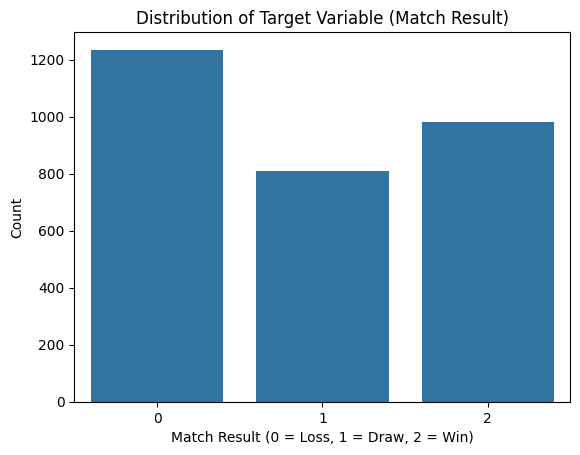

In [26]:
# Plot the distribution of the target variable
sns.countplot(x='target', data=matches_cleaned)
plt.title('Distribution of Target Variable (Match Result)')
plt.xlabel('Match Result (0 = Loss, 1 = Draw, 2 = Win)')
plt.ylabel('Count')
plt.show()

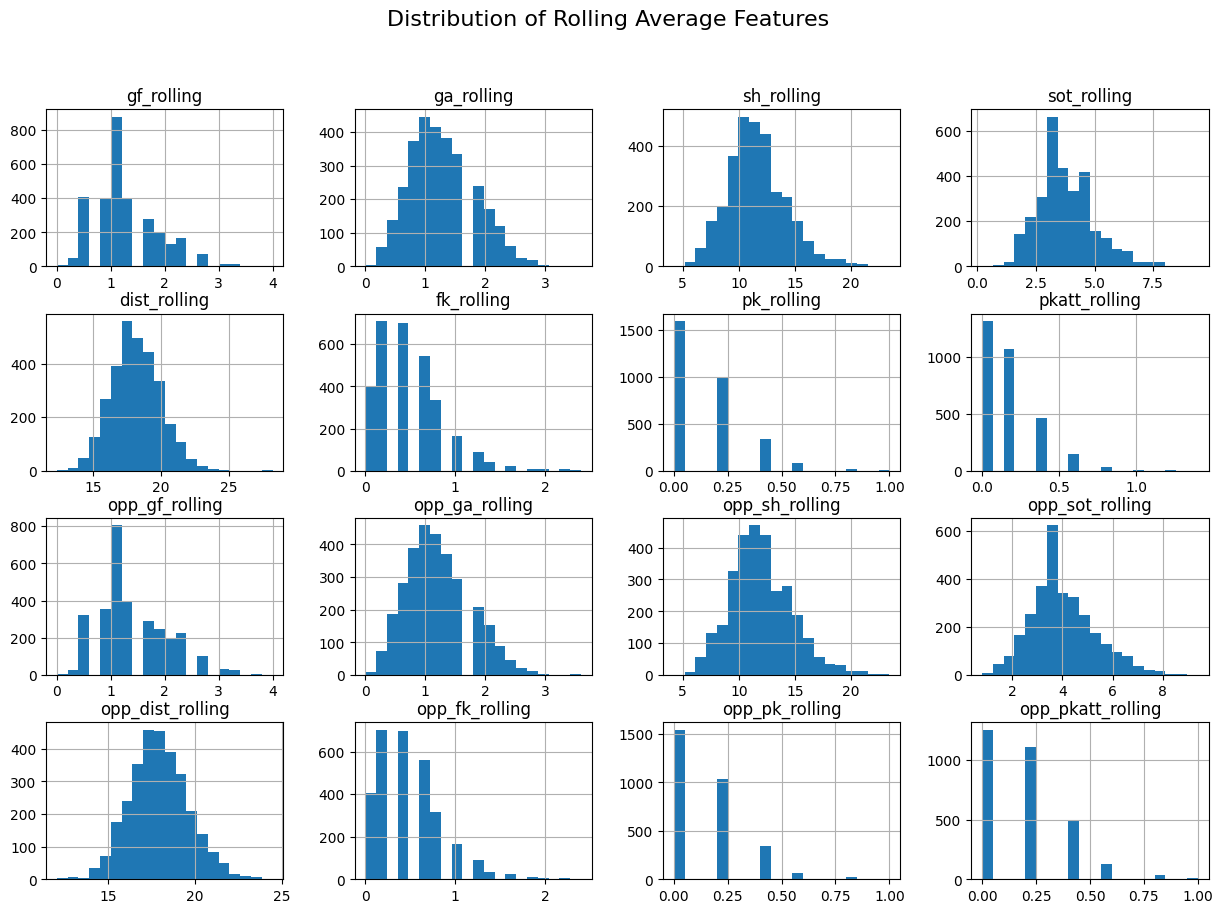

In [27]:
# Plot histograms for numerical columns
numeric_cols = ['gf_rolling', 'ga_rolling', 'sh_rolling', 'sot_rolling',
                'dist_rolling', 'fk_rolling', 'pk_rolling', 'pkatt_rolling',
                'opp_gf_rolling', 'opp_ga_rolling', 'opp_sh_rolling',
                'opp_sot_rolling', 'opp_dist_rolling', 'opp_fk_rolling',
                'opp_pk_rolling', 'opp_pkatt_rolling']

matches_cleaned[numeric_cols].hist(figsize=(15, 10), bins=20, layout=(4, 4))
plt.suptitle('Distribution of Rolling Average Features', fontsize=16)
plt.show()

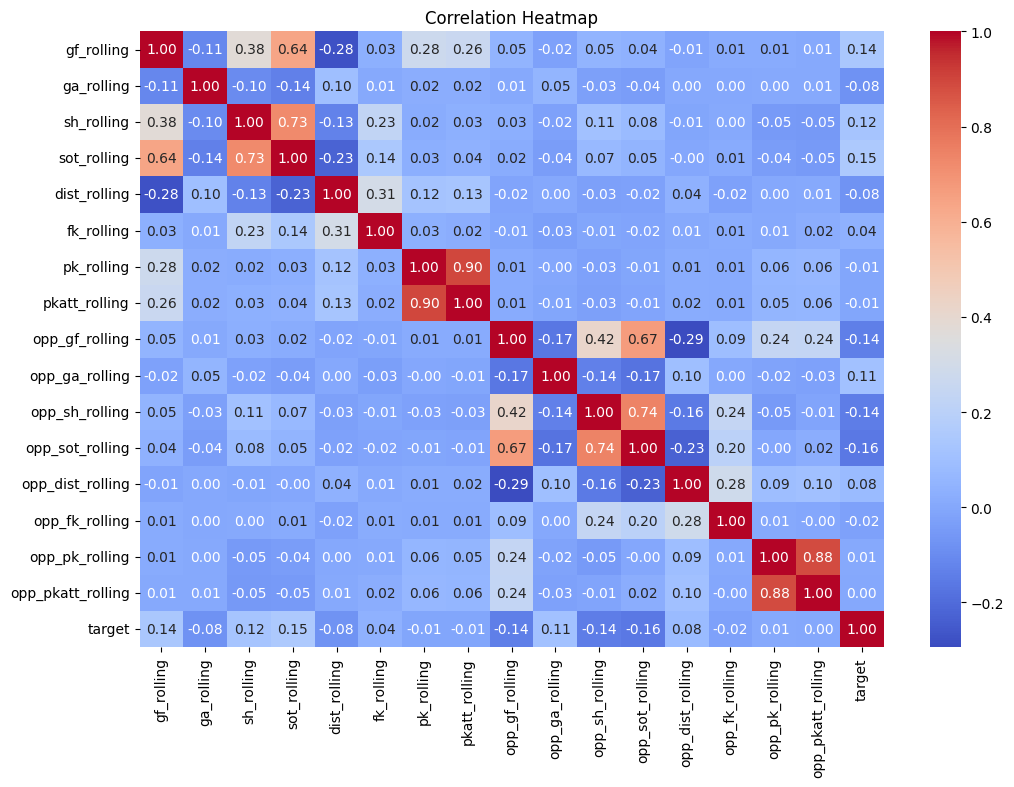

In [28]:
# Compute correlation matrix
corr_matrix = matches_cleaned[numeric_cols + ['target']].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

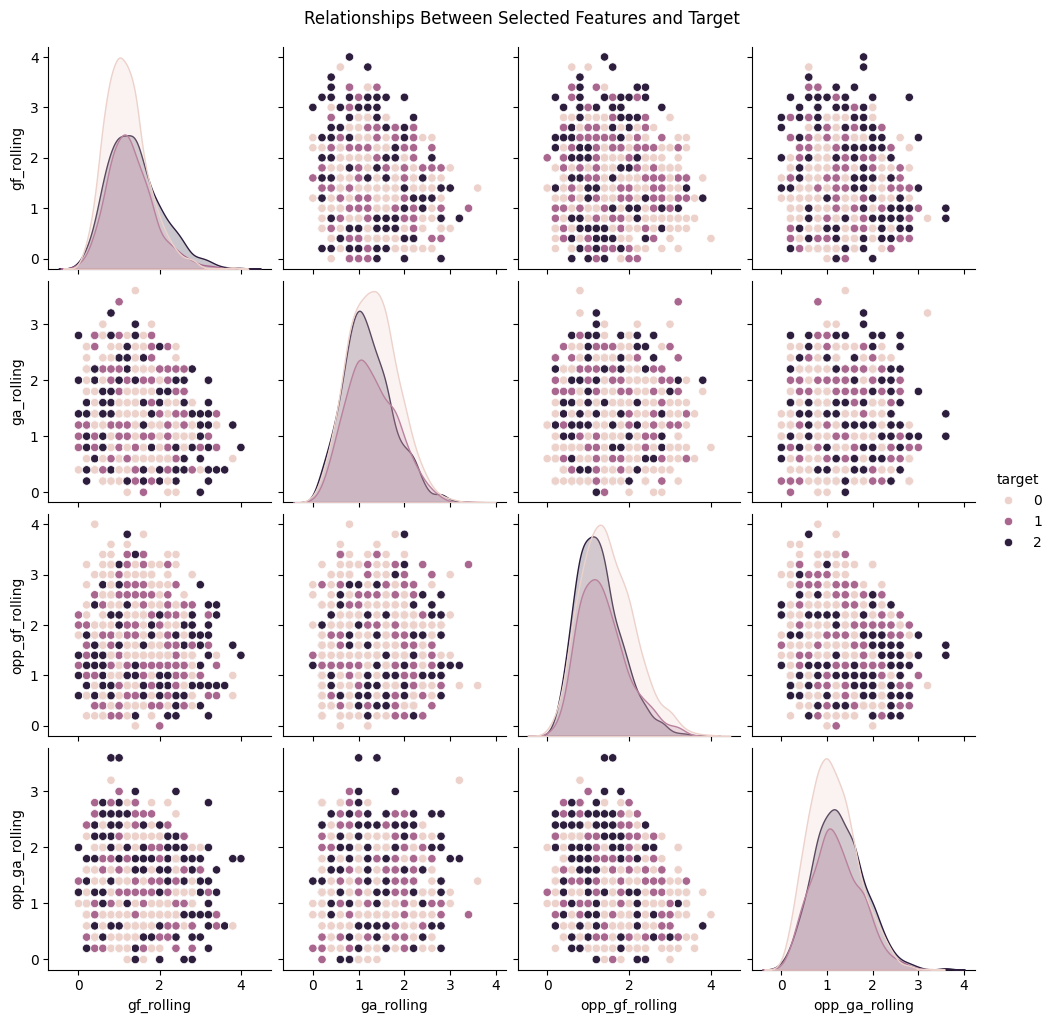

In [29]:
# Pairplot for some selected features and target
selected_features = ['gf_rolling', 'ga_rolling', 'opp_gf_rolling', 'opp_ga_rolling', 'target']
sns.pairplot(matches_cleaned[selected_features], hue='target', diag_kind='kde')
plt.suptitle('Relationships Between Selected Features and Target', y=1.02)
plt.show()

Top-performing teams:


,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,opp_gf_rolling,opp_ga_rolling,opp_sh_rolling,opp_sot_rolling,opp_dist_rolling,opp_fk_rolling,opp_pk_rolling,opp_pkatt_rolling,target
team,,,,,,,,,,,,,,,,,
21,1.940000,0.877143,15.594286,5.694286,18.022857,0.557143,0.205714,0.240000,1.405714,1.111429,11.788571,4.008571,17.859000,0.448571,0.128571,0.158571,1.507143
4,2.130667,0.945333,14.457333,5.586667,17.076800,0.841333,0.137333,0.178667,1.389333,1.130667,12.044000,3.994667,17.811333,0.456000,0.144000,0.184000,1.500000
3,1.637762,0.826573,12.325874,4.423776,17.241678,0.317483,0.097902,0.128671,1.373427,1.225175,11.967832,4.081119,17.963916,0.502098,0.155245,0.202797,1.342657
2,1.247619,1.027211,11.646259,3.699320,17.321361,0.292517,0.129252,0.185034,1.364626,1.198639,11.744218,4.058503,17.942449,0.462585,0.146939,0.185034,0.993197
22,1.315646,1.031293,11.438095,3.869388,17.749660,0.451701,0.142857,0.180952,1.351020,1.182313,11.893878,4.032653,18.079048,0.458503,0.136054,0.186395,0.993197
23,1.385507,1.104348,12.466667,4.011594,17.592464,0.346377,0.115942,0.133333,1.418841,1.215942,11.988406,4.102899,17.804928,0.452174,0.149275,0.195652,0.971014
20,1.328662,1.252229,12.238217,4.105732,18.315414,0.542675,0.151592,0.188535,1.370701,1.141401,12.323567,4.112102,18.194904,0.500637,0.126115,0.171975,0.961783
26,1.566216,1.286486,12.221622,4.331081,16.984459,0.320270,0.156757,0.212162,1.371622,1.255405,12.195946,4.017568,18.055946,0.520270,0.129730,0.158108,0.959459
11,1.641860,1.334884,11.372093,4.109302,17.306047,0.286047,0.202326,0.218605,1.367442,1.290698,12.025581,4.169767,17.747209,0.400000,0.102326,0.141860,0.953488


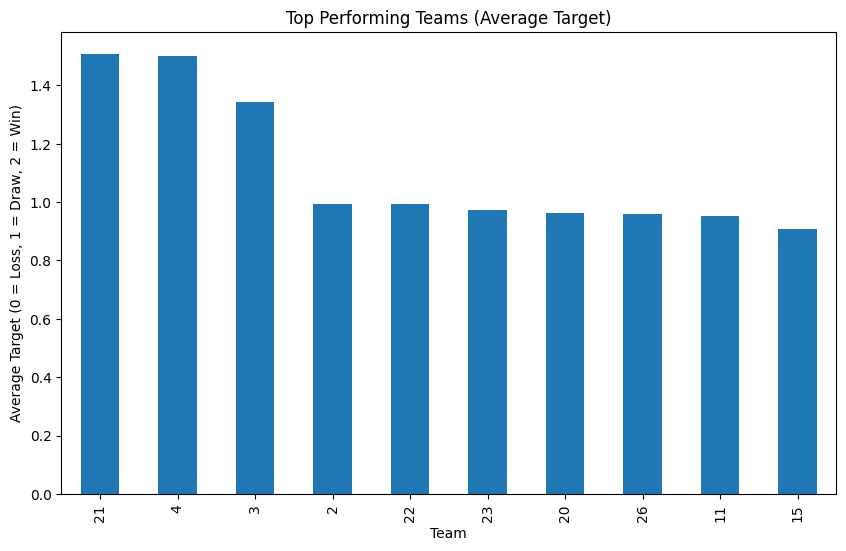

In [30]:
# Group by team to calculate average performance
team_performance = matches_cleaned.groupby('team')[numeric_cols + ['target']].mean()

# Top-performing teams by average target
top_teams = team_performance.sort_values('target', ascending=False).head(10)
print("Top-performing teams:")
display(top_teams)

# Plot average target by team
top_teams['target'].plot(kind='bar', figsize=(10, 6))
plt.title('Top Performing Teams (Average Target)')
plt.ylabel('Average Target (0 = Loss, 1 = Draw, 2 = Win)')
plt.xlabel('Team')
plt.show()

Toughest opponents:


,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,opp_gf_rolling,opp_ga_rolling,opp_sh_rolling,opp_sot_rolling,opp_dist_rolling,opp_fk_rolling,opp_pk_rolling,opp_pkatt_rolling,target
opp_code,,,,,,,,,,,,,,,,,
12,1.090909,1.618182,10.290909,3.127273,18.498182,0.563636,0.127273,0.163636,0.963636,2.018182,11.109091,3.418182,17.972727,0.327273,0.090909,0.218182,0.454545
21,1.303704,1.193416,11.489712,3.795885,18.130700,0.462551,0.139095,0.179424,1.946502,0.845267,15.542387,5.633745,18.109877,0.561317,0.195062,0.240329,0.481481
4,1.278512,1.234711,11.595868,3.754545,18.193719,0.464463,0.142975,0.181818,2.142975,0.944628,14.505785,5.618182,17.079835,0.840496,0.134711,0.176033,0.495868
3,1.290535,1.254321,11.668313,3.886420,18.138930,0.505350,0.138272,0.181893,1.669959,0.859259,12.304527,4.453498,17.226337,0.311111,0.102058,0.130864,0.572016
15,1.280000,0.600000,10.680000,3.400000,19.580000,0.360000,0.160000,0.160000,1.000000,1.520000,7.800000,2.680000,21.512000,0.720000,0.200000,0.200000,0.600000
23,1.296639,1.248739,11.678992,3.816807,18.083529,0.465546,0.147059,0.185714,1.365546,1.130252,12.438655,3.956303,17.616050,0.367227,0.113445,0.130252,0.852941
5,1.193103,1.320690,11.327586,3.662069,18.479310,0.489655,0.106897,0.137931,0.855172,1.355172,9.772414,2.862069,18.362069,0.410345,0.106897,0.144828,0.879310
22,1.291845,1.293562,11.692704,3.901288,18.191073,0.468670,0.134764,0.180258,1.297854,1.031760,11.478112,3.842060,17.729871,0.460086,0.149356,0.186266,0.884120
26,1.269710,1.302905,11.586722,3.768465,18.289461,0.487967,0.127801,0.162656,1.605809,1.293776,12.287967,4.330290,17.023734,0.326971,0.171784,0.226556,0.904564


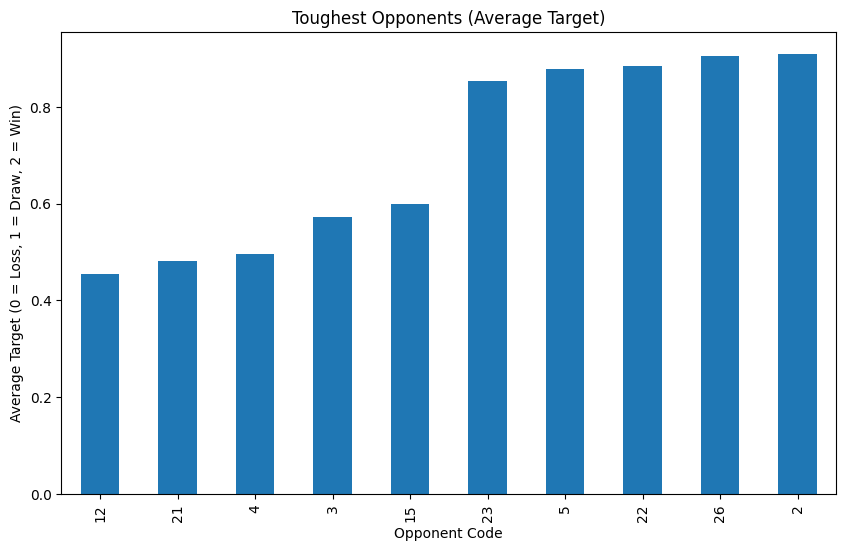

In [31]:
# Group by opponent to calculate average performance
opponent_performance = matches_cleaned.groupby('opp_code')[numeric_cols + ['target']].mean()

# Toughest opponents (lowest average target)
tough_opponents = opponent_performance.sort_values('target').head(10)
print("Toughest opponents:")
display(tough_opponents)

# Plot average target against top opponents
tough_opponents['target'].plot(kind='bar', figsize=(10, 6))
plt.title('Toughest Opponents (Average Target)')
plt.ylabel('Average Target (0 = Loss, 1 = Draw, 2 = Win)')
plt.xlabel('Opponent Code')
plt.show()

In [32]:
matches_cleaned.head()

,date,venue_code,opp_code,hour,day_code,team,gf_rolling,ga_rolling,sh_rolling,sot_rolling,...,pkatt_rolling,opp_gf_rolling,opp_ga_rolling,opp_sh_rolling,opp_sot_rolling,opp_dist_rolling,opp_fk_rolling,opp_pk_rolling,opp_pkatt_rolling,target
0,2018-09-27,1,11,20,3,0,1.6,1.0,9.6,4.0,...,0.0,1.4,1.6,11.0,4.6,18.88,0.6,0.0,0.0,1
2,2018-10-06,1,21,18,5,0,2.0,1.0,11.2,3.8,...,0.2,1.2,1.0,17.4,5.4,18.90,1.0,0.2,0.2,2
3,2018-10-19,0,6,21,4,0,1.8,0.8,11.2,3.6,...,0.2,1.6,2.0,12.2,4.4,18.50,0.8,0.0,0.0,2
4,2018-10-28,1,26,18,6,0,1.8,0.8,11.0,3.2,...,0.2,1.0,1.0,17.2,4.8,18.38,0.2,0.0,0.2,2
8,2018-12-02,1,23,20,6,0,1.2,1.0,11.4,3.6,...,0.0,1.4,1.2,16.2,6.0,16.30,0.2,0.0,0.0,1


# EDA for only Madrid matches

In [33]:
real_madrid_code = 21
rm_matches = matches_cleaned[matches_cleaned['team'] == real_madrid_code].copy()
if rm_matches.empty:
    raise ValueError(f"No data found for team code {real_madrid_code}. Please check the code and your 'matches_cleaned' data.")
else:
    print(f"Filtered data for team code {real_madrid_code}. Shape: {rm_matches.shape}")


Filtered data for team code 21. Shape: (140, 23)


In [34]:
# --- Define Features and Target (using rm_matches, excluding 'team') ---
features = [
    'venue_code', 'opp_code', 'hour', 'day_code',
    'gf_rolling', 'ga_rolling', 'sh_rolling', 'sot_rolling', 'dist_rolling',
    'fk_rolling', 'pk_rolling', 'pkatt_rolling',
    'opp_gf_rolling', 'opp_ga_rolling', 'opp_sh_rolling', 'opp_sot_rolling',
    'opp_dist_rolling', 'opp_fk_rolling', 'opp_pk_rolling', 'opp_pkatt_rolling'
]

# Ensure only existing columns are selected (in case some weren't generated)
features = [col for col in features if col in rm_matches.columns]

X = rm_matches[features]
y = rm_matches['target']

print(f"Features selected for X (Real Madrid model): {X.columns.tolist()}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Features selected for X (Real Madrid model): ['venue_code', 'opp_code', 'hour', 'day_code', 'gf_rolling', 'ga_rolling', 'sh_rolling', 'sot_rolling', 'dist_rolling', 'fk_rolling', 'pk_rolling', 'pkatt_rolling', 'opp_gf_rolling', 'opp_ga_rolling', 'opp_sh_rolling', 'opp_sot_rolling', 'opp_dist_rolling', 'opp_fk_rolling', 'opp_pk_rolling', 'opp_pkatt_rolling']
Shape of X: (140, 20)
Shape of y: (140,)


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_45509/4235143906.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=rm_matches, palette='viridis', order=rm_matches['target'].value_counts().index)


Text(0, 0.5, 'Number of Matches')

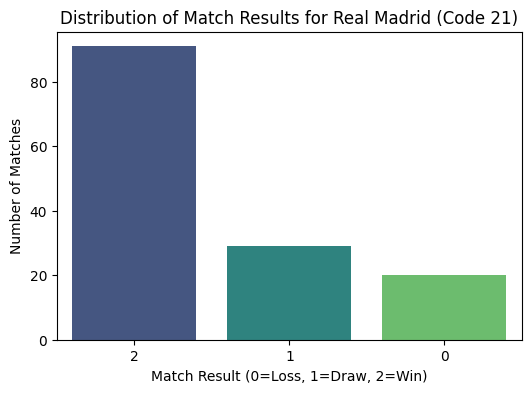

In [35]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=rm_matches, palette='viridis', order=rm_matches['target'].value_counts().index)
plt.title(f'Distribution of Match Results for Real Madrid (Code {real_madrid_code})')
plt.xlabel('Match Result (0=Loss, 1=Draw, 2=Win)')
plt.ylabel('Number of Matches')

In [36]:
rm_numeric_features = X.select_dtypes(include=np.number).columns.tolist() # Select only numeric from features list
rm_corr = rm_matches[rm_numeric_features + ['target']].corr()

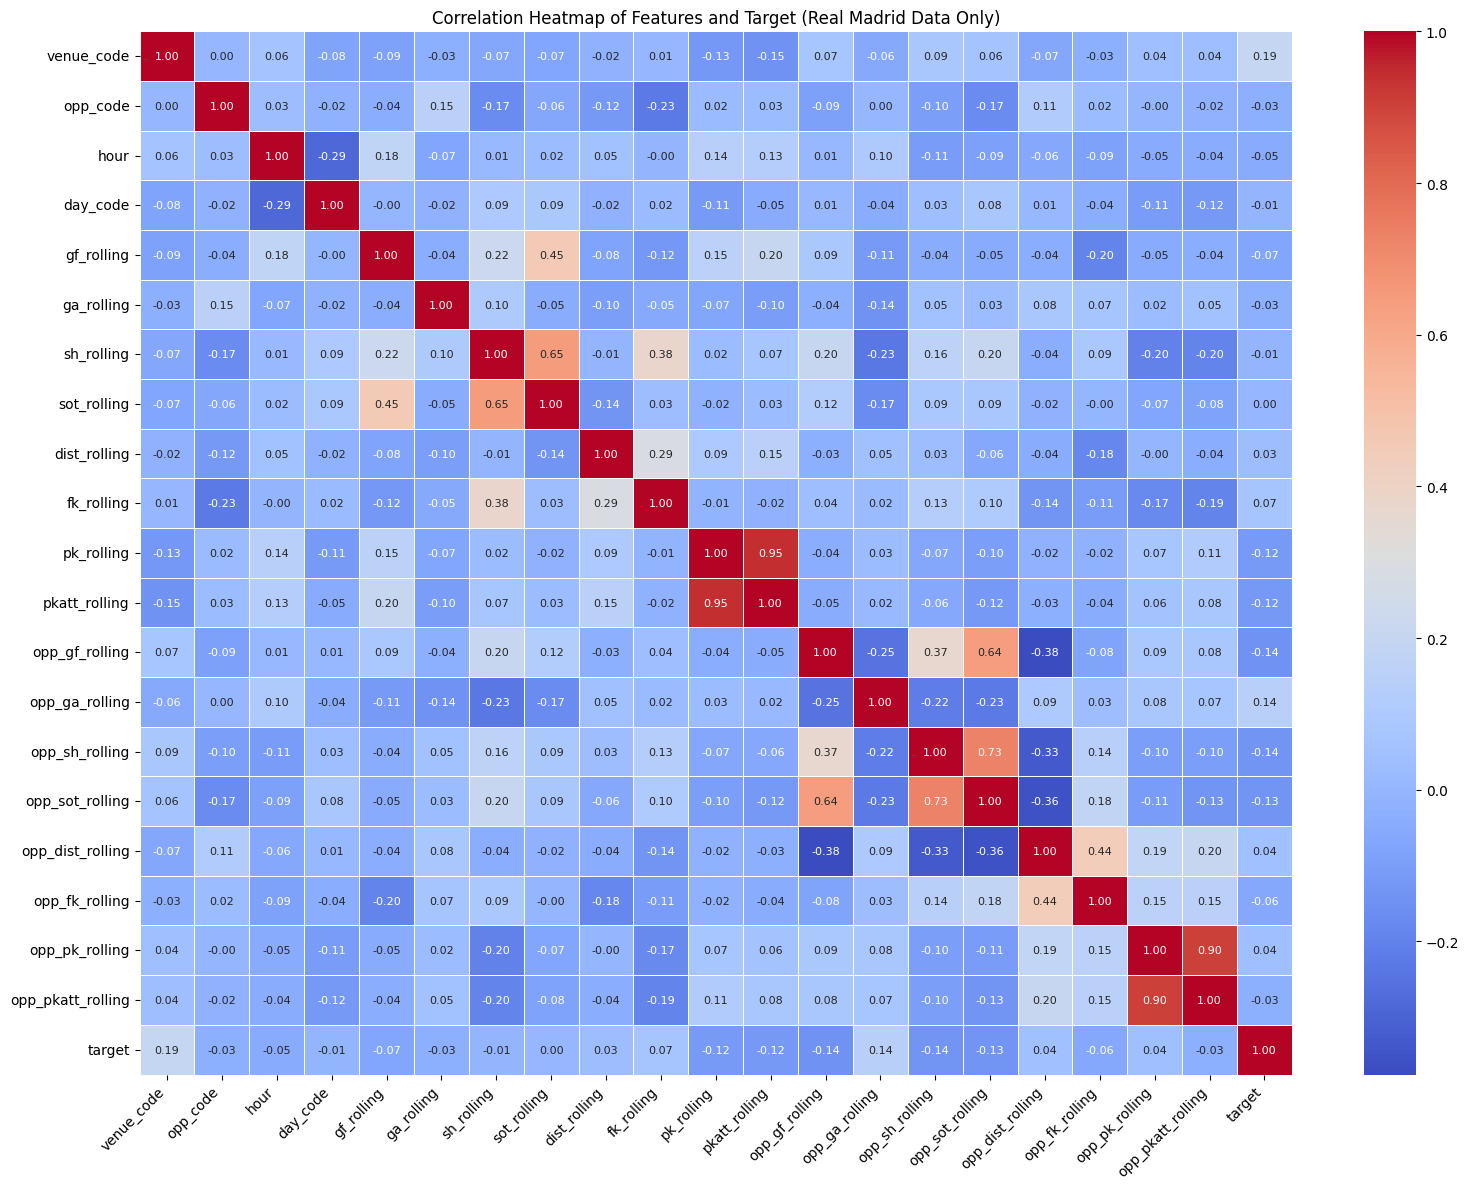


Correlations with Target (Real Madrid Data - Strongest):
target               1.000000
venue_code           0.194950
opp_gf_rolling       0.142145
opp_ga_rolling       0.137349
opp_sh_rolling       0.137246
opp_sot_rolling      0.134576
pkatt_rolling        0.119662
pk_rolling           0.117569
gf_rolling           0.073648
fk_rolling           0.066294
opp_fk_rolling       0.059913
hour                 0.048414
opp_dist_rolling     0.044679
opp_pk_rolling       0.042774
dist_rolling         0.032538
ga_rolling           0.028721
opp_code             0.028457
opp_pkatt_rolling    0.026884
sh_rolling           0.009427
day_code             0.006438
sot_rolling          0.002379
Name: target, dtype: float64


In [37]:
plt.figure(figsize=(16, 12)) # Increased size
sns.heatmap(rm_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, annot_kws={"size": 8}) # Adjusted font size
plt.title('Correlation Heatmap of Features and Target (Real Madrid Data Only)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout
plt.show()
print("\nCorrelations with Target (Real Madrid Data - Strongest):")
print(rm_corr['target'].abs().sort_values(ascending=False))

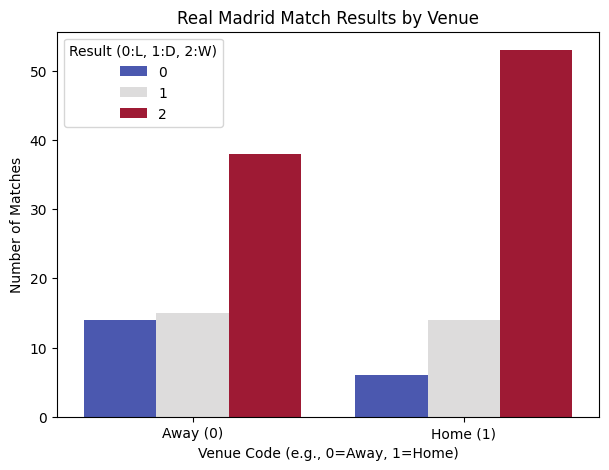


Average Target Score by Venue (0=Away, 1=Home):
venue_code
0    1.358209
1    1.643836
Name: target, dtype: float64


In [38]:
if 'venue_code' in rm_matches.columns:
    plt.figure(figsize=(7, 5))
    sns.countplot(x='venue_code', hue='target', data=rm_matches, palette='coolwarm')
    plt.title('Real Madrid Match Results by Venue')
    plt.xlabel('Venue Code (e.g., 0=Away, 1=Home)')
    plt.ylabel('Number of Matches')
    # Attempt to map codes if possible (adjust if your mapping differs)
    try:
        venue_map = {code: category for code, category in enumerate(matches_cleaned['venue'].astype('category').cat.categories)}
        plt.xticks(ticks=list(venue_map.keys()), labels=list(venue_map.values()))
    except Exception: # Fallback if mapping fails
         plt.xticks([0, 1], ['Away (0)', 'Home (1)']) # Assuming standard 0/1 encoding
    plt.legend(title='Result (0:L, 1:D, 2:W)')
    plt.show()
    print("\nAverage Target Score by Venue (0=Away, 1=Home):")
    # Closer to 2 means better performance (more wins)
    print(rm_matches.groupby('venue_code')['target'].mean())
    # Insight: Is the home advantage significant in this dataset?

In [39]:
if 'opp_code' in rm_matches.columns:
    try:
        # Ensure opponent_mapping exists
        if 'opponent_mapping' not in locals():
             print("Recreating opponent mapping...")
             opponent_mapping = dict(enumerate(matches_cleaned['opponent'].astype('category').cat.categories))

        rm_matches['opponent_name'] = rm_matches['opp_code'].map(opponent_mapping)
        opponent_perf = rm_matches.groupby('opponent_name')['target'].agg(['mean', 'count']).sort_values('mean')
        print("\n--- Performance vs Opponents (Real Madrid Data) ---")
        print("\nLowest Avg Target (Toughest Opponents):")
        print(opponent_perf.head(7)) # Show 7 toughest opponents in this dataset
        print("\nHighest Avg Target (Easiest Opponents):")
        print(opponent_perf.tail(7)) # Show 7 easiest opponents in this dataset

        # Filter out opponents faced only once for a potentially clearer view
        opponents_faced_multiple = opponent_perf[opponent_perf['count'] > 1].sort_values('mean')
        if not opponents_faced_multiple.empty:
            print("\n--- Performance vs Opponents Faced > 1 Time ---")
            print("\nLowest Avg Target (Toughest Frequent Opponents):")
            print(opponents_faced_multiple.head(7))
            print("\nHighest Avg Target (Easiest Frequent Opponents):")
            print(opponents_faced_multiple.tail(7))
        # Insight: Are there specific teams RM struggles against or dominates in this data?

    except Exception as e: # Catch potential errors if mapping fails or columns missing
        print(f"\nWarning: Could not analyze opponent names. Analyzing by opp_code instead. Error: {e}")
        opponent_perf = rm_matches.groupby('opp_code')['target'].agg(['mean', 'count']).sort_values('mean')
        # (print statements using opp_code could be added here)


--- Performance vs Opponents (Real Madrid Data) ---

Lowest Avg Target (Toughest Opponents):
                     mean  count
opponent_name                   
Betis            1.000000      2
Espanyol         1.000000      2
Barcelona        1.153846     13
Villarreal       1.230769     13
Atlético Madrid  1.230769     13
Real Sociedad    1.307692     13
Valencia         1.384615     13

Highest Avg Target (Easiest Opponents):
                   mean  count
opponent_name                 
Athletic Club  1.666667     12
Sevilla        1.692308     13
Valladolid     1.888889      9
Celta Vigo     1.923077     13
Almería        2.000000      3
Mallorca       2.000000      1
Getafe         2.000000      3

--- Performance vs Opponents Faced > 1 Time ---

Lowest Avg Target (Toughest Frequent Opponents):
                     mean  count
opponent_name                   
Betis            1.000000      2
Espanyol         1.000000      2
Barcelona        1.153846     13
Villarreal       1.230769

# Model Training

In [40]:
if 'date' not in rm_matches.columns:
    raise KeyError("The 'date' column is missing from the rm_matches DataFrame.")
if not pd.api.types.is_datetime64_any_dtype(rm_matches['date']):
     rm_matches['date'] = pd.to_datetime(rm_matches['date']) # Convert if needed

min_date = rm_matches['date'].min()
max_date = rm_matches['date'].max()
total_matches = rm_matches.shape[0]

print(f"\n--- Inspecting Date Range for Real Madrid Data (rm_matches) ---")
print(f"Earliest Match Date: {min_date.strftime('%Y-%m-%d')}") # Format date for readability
print(f"Latest Match Date:   {max_date.strftime('%Y-%m-%d')}")
print(f"Total Real Madrid matches available: {total_matches}")



--- Inspecting Date Range for Real Madrid Data (rm_matches) ---
Earliest Match Date: 2018-09-26
Latest Match Date:   2025-01-03
Total Real Madrid matches available: 140


In [41]:
# --- Choose a Split Date ---
# Select a date suitable for the Real Madrid data range.
# You might need to adjust this based on how much RM data you have.
split_date_str = '2024-01-01' # <<< ADJUST THIS DATE AS NEEDED
split_date = pd.to_datetime(split_date_str)

# --- Perform the Split on rm_matches ---
train_df = rm_matches[rm_matches['date'] < split_date].copy()
test_df = rm_matches[rm_matches['date'] >= split_date].copy()

# Separate features and target for train and test sets
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

print(f"\nTraining data shape (X_train - RM only): {X_train.shape}")
print(f"Testing data shape (X_test - RM only): {X_test.shape}")

if not X_train.empty:
    print(f"Training period ends: {train_df['date'].max()}")
else:
    print("Warning: Training set is empty!")

if not X_test.empty:
    print(f"Testing period starts: {test_df['date'].min()}")
else:
    print("Warning: Test set is empty! Adjust the split_date.")

# Crucial Check: Ensure both sets have data
if X_train.empty or X_test.empty:
     raise ValueError("Training or Test set is empty after split. Adjust split_date or check filtered data.")


Training data shape (X_train - RM only): (117, 20)
Testing data shape (X_test - RM only): (23, 20)
Training period ends: 2023-12-21 00:00:00
Testing period starts: 2024-01-21 00:00:00



--- Applying SMOTE to Training Data ---
Original training data shape: X=(117, 20), y=(117,)
Original training distribution (%):
target
2    64.957265
1    19.658120
0    15.384615
Name: proportion, dtype: float64

SMOTE applied successfully.
--- Resampled Training Data Distribution ---
target
0    33.333333
1    33.333333
2    33.333333
Name: proportion, dtype: float64
Shape of X_train after SMOTE: (228, 20)

Defined RandomForestClassifier model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2526, 'verbose': 0, 'warm_start': False}

--- Training Final Random Forest model on SMOTE-resampled data ---
Model training complete.

--- Evaluating model on ORIGINAL test 

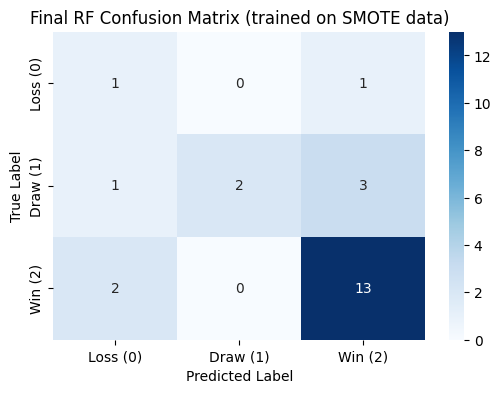

In [42]:
smote = SMOTE(random_state=2526) # Use consistent random state
print("\n--- Applying SMOTE to Training Data ---")
# Ensure X_train, y_train exist and are correctly defined from the split
try:
    print(f"Original training data shape: X={X_train.shape}, y={y_train.shape}")
    print("Original training distribution (%):")
    print(y_train.value_counts(normalize=True) * 100)

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("\nSMOTE applied successfully.")
    print("--- Resampled Training Data Distribution ---")
    print(y_train_resampled.value_counts(normalize=True) * 100)
    print(f"Shape of X_train after SMOTE: {X_train_resampled.shape}")

    # --- Define the Final Random Forest Model (Non-Tuned) ---
    # Using parameters similar to your previous successful run
    final_rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=2526, # Use consistent random state
        min_samples_split=3 # Your previous setting
        # No class_weight here as SMOTE handles imbalance
    )
    print(f"\nDefined RandomForestClassifier model: {final_rf_model.get_params()}")

    # --- Train the model on the RESAMPLED data ---
    print("\n--- Training Final Random Forest model on SMOTE-resampled data ---")
    final_rf_model.fit(X_train_resampled, y_train_resampled)
    print("Model training complete.")

    # --- Make predictions on the ORIGINAL test data ---
    print("\n--- Evaluating model on ORIGINAL test data ---")
    # Ensure X_test, y_test exist
    y_pred = final_rf_model.predict(X_test)

    # --- Evaluate the model ---
    print("\nFinal Random Forest (trained on SMOTE data) Evaluation:")
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, labels=[0, 1, 2], target_names=['Loss', 'Draw', 'Win'])
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

    print(f"Accuracy: {accuracy:.4f}") # Should be ~0.6957 based on your comment
    print("Classification Report:")
    print(report)
    print("Confusion Matrix (Rows: True, Cols: Predicted):")
    print(conf_matrix)

    # --- Store final results ---
    final_model_results = {
        "Random Forest (SMOTE)": { # Key reflects the method used
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'model_object': final_rf_model # Store the trained model
        }
    }
    print("\nResults stored in 'final_model_results'.")

    # --- Visualize Confusion Matrix ---
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss (0)', 'Draw (1)', 'Win (2)'],
                yticklabels=['Loss (0)', 'Draw (1)', 'Win (2)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Final RF Confusion Matrix (trained on SMOTE data)')
    plt.show()

except NameError as e:
        print(f"Error: Make sure X_train, y_train, X_test, y_test are defined before this block. {e}")
except Exception as e:
    print(f"An error occurred during SMOTE or subsequent training/evaluation: {e}")


In [44]:
print("\n--- Final Model Summary ---")
if 'final_model_results' in locals() and "Random Forest (SMOTE)" in final_model_results:
     results = final_model_results["Random Forest (SMOTE)"]
     print(f"Final Model Chosen: Random Forest (SMOTE)")
     print(f"Test Accuracy: {results['accuracy']:.4f}")
     try:
        report_dict = classification_report(y_test, results['model_object'].predict(X_test), output_dict=True, zero_division=0, labels=[0, 1, 2])
        print(f"Test Weighted F1-Score: {report_dict['weighted avg']['f1-score']:.4f}")
     except Exception as e:
        print(f"Could not calculate F1-Score for summary. Error: {e}")
else:
     print("Final model results are not available.")



--- Final Model Summary ---
Final Model Chosen: Random Forest (SMOTE)
Test Accuracy: 0.6957
Test Weighted F1-Score: 0.6893


Removing the three features (fk_rolling, pkatt_rolling, opp_dist_rolling), even though they had zero or negative permutation importance on the test set, resulted in a significant decrease in both Accuracy and Weighted F1-Score.